# Toy Distributions for L2HMC

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import setup_directories, train_dynamics
from dynamics.base_dynamics import BaseDynamics
from dynamics.generic_dynamics import GenericDynamics
from network.generic_network import GenericNetwork
from config import (State, NetWeights, MonteCarloStates,
                    DynamicsConfig, NetworkConfig, LearningRateConfig,
                    BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

sns.set_palette('bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2020-09-08 15:04:32,137:INFO:Number of devices: 1


## Helper functions

In [2]:
def identity(x):
    return x

def get_dynamics(flags):
    """Return `GenericDynamics` object, initialized from `flags`."""
    config = DynamicsConfig(eps=flags.eps,
                            num_steps=flags.num_steps,
                            hmc=flags.hmc,
                            eps_fixed=flags.eps_fixed,
                            model_type=flags.model_type)


    net_config = NetworkConfig(units=flags.units,
                               dropout_prob=flags.dropout_prob,
                               name=flags.network_name,
                               activation_fn=flags.activation_fn)

    lr_config = LearningRateConfig(flags.lr_init,
                                   lr_decay_steps=flags.lr_decay_steps,
                                   decay_rate=flags.decay_rate,
                                   warmup_steps=flags.warmup_steps)

    dynamics = GenericDynamics(params=flags,
                               config=config,
                               lr_config=lr_config,
                               normalizer=identity,
                               network_config=net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
    
    return dynamics

In [3]:
import utils.file_io as io
from utils.distributions import contour_potential

%matplotlib inline

def plot_chains(dirs, x_arr, potential_fn, label=None, cmap='rainbow'):
    figs_dir = os.path.join(dirs.log_dir, 'figures')
    io.check_else_make_dir(figs_dir)

    x_arr = tf.convert_to_tensor(x_arr).numpy()

    for chain in range(4):
        fig, ax = plt.subplots()
        xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
        #sns.kdeplot(*xy, ax=ax)
        #grid = xy.reshape(2, -1).T
        #Z = np.exp(-POTENTIAL_FN(grid))
        #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
        #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
        #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
        xlim = 5
        ylim = 5
        _ = contour_potential(POTENTIAL_FN, ax=ax, cmap='rainbow', xlim=xlim, ylim=ylim)
        _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                    color='white', label='l2hmc samples')
        #_ = ax.legend(markerscale=5., loc='best')
        _ = ax.set_xlim((-xlim, xlim))
        _ = ax.set_ylim((-ylim, ylim))
        out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        plt.show()

In [4]:
def plot_density_estimation(potential_fn, x_l2hmc, x_hmc,
                            title=None, cmap=None, num_plots=5):
    def _format_arr(x):
        x = np.array(x)
        n = x.shape[0]
        therm = 2 * n // 10  # Drop first 20% of samples (thermalization)
        return x[therm:]
    
    x_l2hmc = _format_arr(x_l2hmc)
    x_hmc = _format_arr(x_hmc)
    
    for idx in range(num_plots):
        fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
        _ = contour_potential(potential_fn, title=title, ax=axes[0], cmap=cmap)
        _ = sns.kdeplot(x_l2hmc[:, idx, 0], x_l2hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[1])
        _ = sns.kdeplot(x_hmc[:, idx, 0], x_hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[2])
        _ = axes[1].set_title('L2HMC samples')
        _ = axes[2].set_title('HMC samples')
        plt.tight_layout()
        
    return fig, axes

### Plot examples of (toy) target distributions:

In [5]:
%matplotlib inline

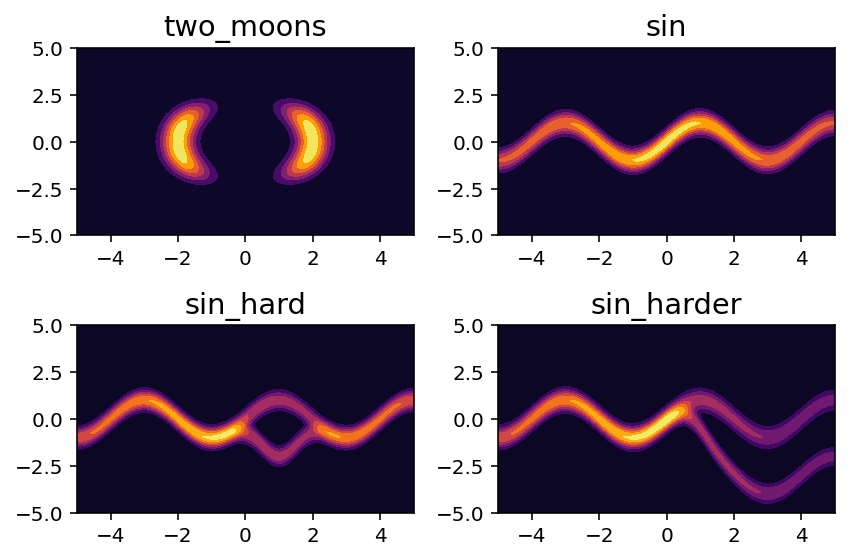

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons', 'sin', 'sin_hard', 'sin_harder']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
potentials_dict = {}
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}')
    potentials_dict[names[idx]] = p_fn
plt.show()

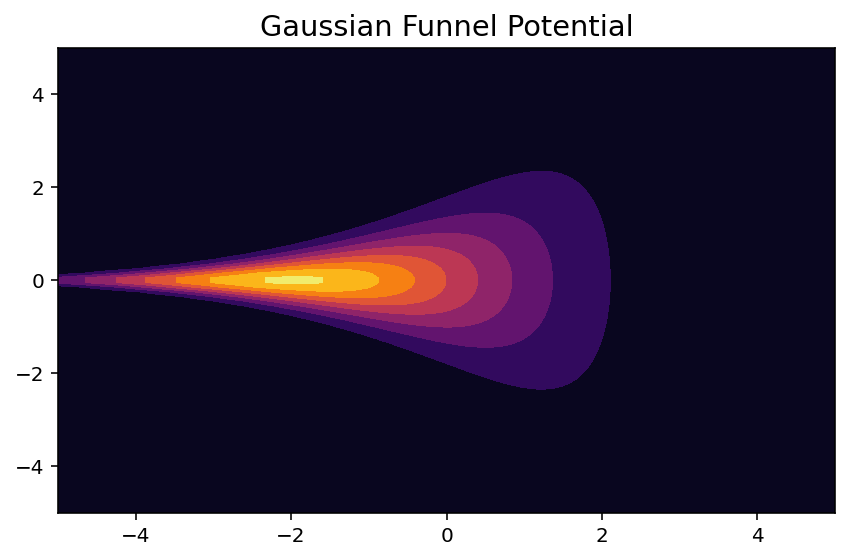

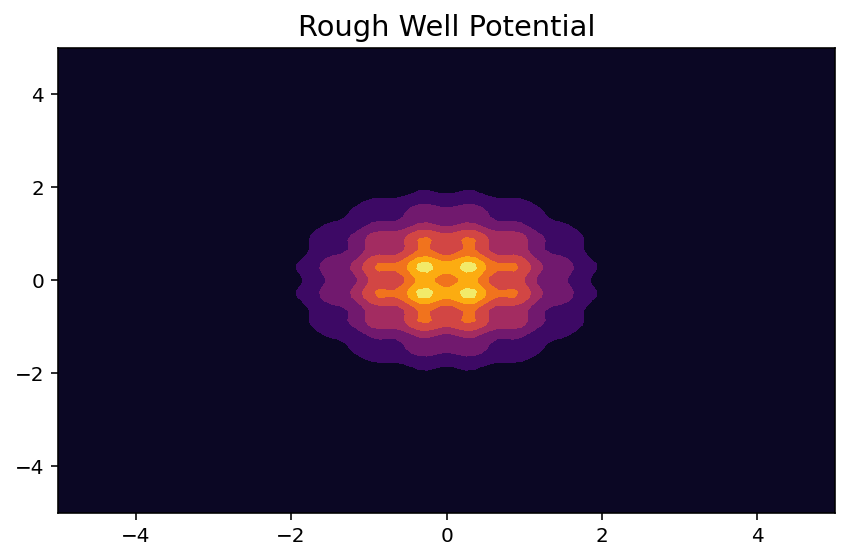

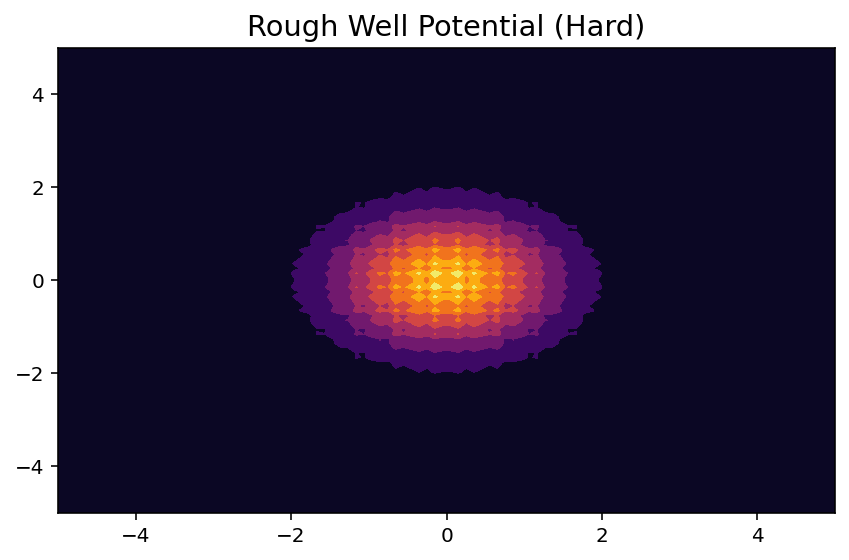

In [7]:
from utils.distributions import GaussianFunnel, RoughWell

funnel = GaussianFunnel()
funnel_potential = funnel.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(funnel_potential, ax=ax, title=f'Gaussian Funnel Potential')
plt.show()

rough_well = RoughWell(dim=2, eps=0.1, easy=True)
rw_potential = rough_well.get_energy_function()

fig, ax = plt.subplots()
_ = contour_potential(rw_potential, ax=ax, title=f'Rough Well Potential')
plt.show()

rough_well_hard = RoughWell(dim=2, eps=0.1, easy=False)
rwh_potential = rough_well_hard.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(rwh_potential, ax=ax, title=f'Rough Well Potential (Hard)')
plt.show()

potentials_dict.update({
    'funnel': funnel_potential,
    'rough_well': rw_potential,
    'rough_well_hard': rwh_potential,
})

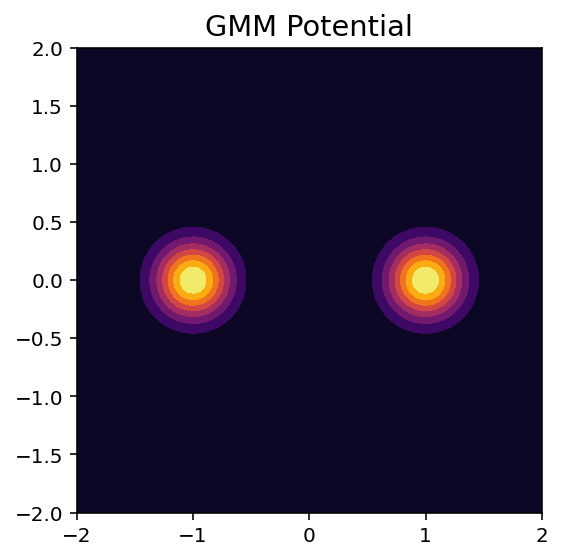

In [8]:
from utils.distributions import GMM

pis = np.array([0.5, 0.5])
mus = np.array([(-1, 0), (1, 0)])
sigmas = np.array([0.05 * np.eye(2), 0.05 * np.eye(2)])

gmm = GMM(mus, sigmas, pis)

gmm_potential = gmm.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(gmm_potential, ax=ax, title='GMM Potential', xlim=2, ylim=2)
ax.set_aspect('equal')
plt.show()

potentials_dict.update({
    'GMM': gmm_potential,
})

## Define parameters of the model and target distribution

In [12]:
import utils.file_io as io
import datetime

LOGS_DIR = os.path.abspath('../../logs')

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE = 'two_moons'
POTENTIAL_FN = potentials_dict[MODEL_TYPE]

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')

log_dir = os.path.join(LOGS_DIR, f'{MODEL_TYPE}', date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)
    
io.check_else_make_dir(log_dir)


flags = AttrDict({
    'restore': False,
    'horovod': False,
    'profiler': False,
    'xdim': 2,
    'eps': 0.1,
    'batch_size': 512,
    'num_steps': 10,
    'beta_init': 0.5,
    'beta_final': 1.,
    'compile': True,
    'hmc_steps': 0,
    'lr_init': 1e-3,
    'train_steps': 10000,
    'clip_val': 1.0,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 10,
    'warmup_steps': 1000,
    'print_steps': 100,
    'units': [100, 100],
    'hmc': False,
    'eps_fixed': False,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.25,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.lr_decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

2020-09-08 15:10:32,855:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032


## Train

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [16]:
flags.hmc_steps = 10000

x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = LearningRateConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
    hmc_flags = AttrDict(dict(flags))
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 10000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_trainable=flags.eps_trainable,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    flags.eps = hmc_dynamics.eps.numpy()

AttributeError: 'AttrDict' object has no attribute 'decay_steps'

In [7]:
flags.eps = hmc_dynamics.eps.numpy()

### Create `GenericDynamics` object

In [13]:
dynamics = get_dynamics(flags)

### Train L2HMC sampler using HMC sampler as starting point

In [14]:
flags.print_steps = 10
dirs = setup_directories(flags)
x = tf.random.normal(dynamics.x_shape)
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

2020-09-08 15:10:45,780:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/training
2020-09-08 15:10:45,783:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/training/train_data
2020-09-08 15:10:45,786:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/training/checkpoints
2020-09-08 15:10:45,788:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/training/summaries
2020-09-08 15:10:45,790:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/training/dynamics_configs
2020-09-08 15:10:45,794:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/training/FLAGS.z.
2020-09-08 15:10:48,363:INFO:************************************************************************************************************************
2020-09-08 15:11:20,610:INF

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/10000    0.1052      2.513       0.9271       0.1         0.5      -0.001094  
    10/10000    0.0882      3.019       0.9428     0.09998      0.5003    -0.001955  
    20/10000   0.09774       2.71       0.9382     0.09996      0.5007    -0.001299  
    30/10000   0.08272       2.32       0.9423     0.09999      0.501      0.004967  
    40/10000   0.09087      2.025       0.9419       0.1        0.5014     0.001922  
    50/10000   0.08975      1.921       0.9443       0.1        0.5017     0.002889  
    60/10000   0.09617      3.063       0.9405      0.1001      0.5021    0.0003235  
    70/10000   0.08425      1.745       0.937       0.1002      0.5024    0.0002609  
    80/10000   0.08934      13.58       0.9401      0.100

   930/10000    0.1265       1.52       0.6555      0.1233      0.5333     0.003145  
   940/10000    0.1074      6.882       0.5894      0.1229      0.5337    -0.001572  
   950/10000    0.1122      1.885       0.6283      0.1227      0.534      0.001419  
   960/10000    0.105       1.716       0.6437      0.1221      0.5344     0.002173  
   970/10000    0.1061      2.781       0.6642      0.1219      0.5348    0.0002997  
   980/10000    0.108       0.7971      0.6689      0.1222      0.5351     0.002781  
   990/10000    0.1271      1.358       0.6496      0.1238      0.5355    -0.001787  
  1000/10000    0.1009      0.7564      0.6485      0.1255      0.5359    -0.005328  
  1010/10000    0.1171      3.928       0.6077      0.1259      0.5363      0.0016   
  1020/10000   0.09926      2.194       0.5849      0.1255      0.5366     0.002166  
  1030/10000    0.1122      3.417       0.6463      0.1231      0.537     -0.004101  
  1040/10000    0.1046      5.168       0.629       0.

  1890/10000    0.1565       5.55       0.5533      0.1229       0.57     -0.001559  
  1900/10000    0.1673      2.758       0.5038      0.125       0.5704    -0.0008675 
  1910/10000    0.1774      14.67       0.5212      0.1267      0.5708    -0.000984  
  1920/10000    0.1852      4.611       0.4507      0.1284      0.5712    -0.0005867 
  1930/10000    0.1643      3.855       0.4705      0.1244      0.5716    -0.0002621 
  1940/10000    0.1917      5.688       0.5778      0.1141      0.572       0.0002   
  1950/10000    0.143       2.323       0.6073      0.1073      0.5724     0.001839  
  1960/10000    0.1323      3.946       0.6158      0.1052      0.5728    -0.004268  
  1970/10000    0.1321      2.563       0.6151      0.1047      0.5732     0.002947  
  1980/10000    0.1276       3.2        0.6198      0.1047      0.5736    -0.003786  
  1990/10000    0.127       4.009       0.6422      0.106       0.574     0.0003806  
  2000/10000    0.1711      4.139       0.6594      0.

  2850/10000    0.1205      4.847       0.709      0.07339      0.6092    -0.0008534 
  2860/10000     0.16       3.577       0.6486     0.07742      0.6096    0.0008809  
  2870/10000    0.1579      1.976       0.655      0.07892      0.6101    -0.001134  
  2880/10000    0.1518      4.629       0.6446     0.07939      0.6105    -0.001327  
  2890/10000    0.1451      2.445       0.6369     0.07944      0.6109     0.002765  
  2900/10000    0.1574      12.79       0.6188     0.07898      0.6113    0.0003496  
  2910/10000    0.1477       4.11       0.6477     0.07819      0.6118    -5.073e-05 
  2920/10000    0.1477      4.678       0.6633     0.07991      0.6122    -0.001931  
  2930/10000    0.1465      2.985       0.6609     0.08487      0.6126     0.001521  
  2940/10000    0.1473      2.714       0.6333     0.08995      0.613     0.0007142  
  2950/10000    0.154       3.158       0.6048     0.09381      0.6135    -0.0002004 
  2960/10000    0.1569      1.774       0.6182     0.0

  3810/10000    0.1641     -0.9657      0.5262     0.06983      0.6511     0.002032  
  3820/10000    0.153       -1.195      0.5607     0.06972      0.6516    -0.001935  
  3830/10000    0.1538     -0.4116      0.548      0.06959      0.652      0.001163  
  3840/10000    0.1587      -1.367      0.5392     0.06963      0.6525    0.0005181  
  3850/10000    0.1453      -2.228      0.5775     0.06991      0.6529    -0.001341  
  3860/10000    0.1688      2.777       0.5527     0.06992      0.6534     0.001799  
  3870/10000    0.1422     -0.8881      0.5228     0.07007      0.6539      0.004    
  3880/10000    0.1417      -1.504      0.5119     0.07024      0.6543    0.0008825  
  3890/10000    0.1394      -1.782      0.5256     0.07034      0.6548    -0.0004875 
  3900/10000    0.1612     -0.7445      0.5074     0.07023      0.6552     -0.00201  
  3910/10000    0.1395      -2.264      0.4882     0.06937      0.6557     0.002717  
  3920/10000    0.136       -2.628      0.5416     0.0

  4770/10000    0.1377      -13.28      0.7083      0.0801      0.6959     0.001709  
  4780/10000    0.1414      -14.07      0.757      0.07995      0.6964     0.001424  
  4790/10000    0.1377      -13.67      0.7523     0.07979      0.6969    -0.001195  
  4800/10000    0.1419      -13.41      0.7446      0.0794      0.6974     0.001682  
  4810/10000    0.1292      -13.01      0.7494     0.07916      0.6979    -0.002442  
  4820/10000    0.1587      -13.59      0.7479     0.07893      0.6984     0.004245  
  4830/10000    0.1459      -14.22      0.7662     0.07908      0.6989    -0.0004205 
  4840/10000    0.1277      -13.55      0.7432     0.07855      0.6993    -0.0004901 
  4850/10000    0.2248      -13.63      0.7431     0.07816      0.6998    0.0004378  
  4860/10000    0.186       -13.84      0.7486     0.07829      0.7003    -0.0004259 
  4870/10000    0.1666      -13.19      0.7189     0.07839      0.7008    -0.002547  
  4880/10000    0.1408      -14.63      0.7834      0.

  5700/10000    0.1786      -14.53      0.7928     0.06939      0.7423    0.0004714  
  5710/10000    0.1708      -14.5       0.8035     0.06918      0.7428     0.000979  
  5720/10000    0.1687      -14.81      0.8098     0.06896      0.7433    -0.001015  
  5730/10000    0.159       -14.8       0.8027     0.06896      0.7438    0.0004631  
  5740/10000    0.1574      -15.15      0.8113     0.06879      0.7444    -0.0003206 
  5750/10000    0.145       -14.71      0.7778     0.06859      0.7449    -0.001797  
  5760/10000    0.1419      -15.2       0.8146     0.06822      0.7454     0.001056  
  5770/10000    0.1723      -14.88      0.806      0.06812      0.7459     0.00291   
  5780/10000    0.1558      -14.49      0.7977     0.06828      0.7464    -0.000152  
  5790/10000    0.1769      -14.75      0.8041     0.06794      0.7469     0.004779  
  5800/10000    0.1871      -15.43      0.7921     0.06773      0.7475    0.0005798  
  5810/10000    0.1545      -14.99      0.7845     0.0

  6660/10000    0.1094      -15.47      0.8287     0.05903      0.7934    0.0004116  
  6670/10000   0.09024       -15        0.8241     0.05891      0.7939     0.002071  
  6680/10000   0.09535      -15.08      0.8101      0.0589      0.7945     0.002143  
  6690/10000   0.08876      -15.55      0.8395     0.05883      0.795     -0.0001333 
  6700/10000   0.08816      -15.74      0.8331     0.05854      0.7956    -0.003551  
  6710/10000   0.08452      -15.84      0.8305      0.0586      0.7961    -0.001487  
  6720/10000    0.1038      -15.97      0.8352     0.05843      0.7967     0.00192   
  6730/10000    0.0813      -15.22      0.8139     0.05831      0.7972     0.000447  
  6740/10000   0.08586      -15.65      0.833      0.05812      0.7978    -0.001523  
  6750/10000   0.08468      -15.1       0.8305      0.058       0.7983     0.001242  
  6760/10000   0.08549      -15.29      0.8221     0.05795      0.7989    -0.002068  
  6770/10000   0.09407      -15.26      0.8198     0.0

  7620/10000   0.09941      -15.9       0.8432     0.05047      0.848     0.0001583  
  7630/10000    0.1099      -15.8       0.8505     0.05095      0.8486    0.0007829  
  7640/10000   0.09622      -15.74      0.8435     0.05051      0.8491    -0.0004946 
  7650/10000    0.1114      -15.81      0.8479      0.0505      0.8497    -0.001031  
  7660/10000    0.1206      -15.39      0.8327     0.05044      0.8503    0.0001516  
  7670/10000    0.1096      -15.73      0.8435     0.05022      0.8509     0.001516  
  7680/10000    0.1021      -15.36      0.8347     0.05022      0.8515    -0.002335  
  7690/10000    0.1034      -15.65      0.8511     0.04997      0.8521    -0.0003434 
  7700/10000   0.09962      -15.86      0.8468     0.05026      0.8527    -0.001403  
  7710/10000    0.1043      -16.24      0.8611     0.04985      0.8533    0.0001891  
  7720/10000    0.1116      -15.81      0.8405     0.05008      0.8539    0.0003901  
  7730/10000   0.09163      -15.67      0.8514      0.

  8580/10000    0.1282      -16.23      0.8628     0.04378      0.9063    -0.0003594 
  8590/10000    0.1317      -16.35      0.8707      0.0439      0.907     0.0001401  
  8600/10000    0.1345      -16.56      0.8604     0.04394      0.9076    0.0004287  
  8610/10000    0.124       -16.21      0.8503     0.04356      0.9082    0.0009638  
  8620/10000    0.1327      -15.18      0.8708     0.04352      0.9088    0.0001036  
  8630/10000    0.1257      -15.36      0.853      0.04389      0.9095    -0.000903  
  8640/10000    0.131       -15.2       0.8445     0.04338      0.9101    -0.0002304 
  8650/10000    0.1424      -15.92      0.8532     0.04331      0.9107    -0.002087  
  8660/10000    0.1276      -15.9       0.8576     0.04337      0.9114     -0.00224  
  8670/10000    0.1215      -15.95      0.8635     0.04361      0.912     0.0007315  
  8680/10000    0.1361      -16.18      0.8665     0.04332      0.9126    0.0001767  
  8690/10000    0.1211      -15.97      0.8637     0.0

  9540/10000    0.1831      -15.47      0.8528     0.03879      0.9687    -0.0005842 
  9550/10000    0.1654      -15.84      0.8698      0.0386      0.9694    0.0001916  
  9560/10000    0.1627      -15.66      0.8712     0.03834       0.97      0.000499  
  9570/10000    0.1482      -16.15      0.8687     0.03822      0.9707    -0.0007264 
  9580/10000    0.1453      -15.88      0.8749     0.03842      0.9714    -0.0003484 
  9590/10000    0.182       -15.71      0.869      0.03816      0.9721    -0.000302  
  9600/10000    0.1596      -15.72      0.8624     0.03789      0.9727    -0.0008464 
  9610/10000    0.1367      -16.02      0.8629     0.03835      0.9734    -0.0002997 
  9620/10000    0.1836      -15.86      0.8578     0.03876      0.9741    0.0002243  
  9630/10000    0.1462      -16.07      0.8665     0.03854      0.9748     0.000253  
  9640/10000    0.1615      -16.36      0.8744     0.03822      0.9754    -0.0001031 
  9650/10000    0.1526      -15.78      0.8486     0.0

## Run inference

In [15]:
import utils.file_io as io

dirs = setup_directories(flags)

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

2020-09-08 16:25:58,983:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/training/FLAGS.z.
2020-09-08 16:25:58,985:INFO:INFO:Checkpoint restored from: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/training/checkpoints/ckpt-11


In [16]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-09-08 16:26:02,126:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-08/2020-09-08-151032/inference/summaries
2020-09-08 16:26:02,128:INFO:Running inference with:
 beta: 1.0
eps: 0.03666
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.01686      -23.18      0.9097     0.03666        1       0.0003845  
    10/5000    0.01066      -22.15      0.926      0.03666        1        -0.00152  
    20/5000    0.01146      -21.64      0.9317     0.03666        1       -3.92e-05  
    30/5000    0.01056      -20.9       0.9417     0.03666        1       0.0005347  
    40/5000    0.01133      -20.61      0.9519     0.03666        1       -0.001484  
    50/5000    0.01044      -19.85      0.9486     0.03666        1       2.653e-05  
    60/5000     0.0124      -19.9       0.951      0.03666        1        0.001202  
    70/5000    0.01119      -19.59      0.9553     0.03666        1       0.0004958  
    80/5000    0.01178      -19.17      0.953      0.03666        1        2.91e-05  
    90/5000    0.01009      -18.73      0.9518     0.03666        1       -0.001117  
   100/5000    0.009707     -18.44      0.957      0.03666        1       -0.001345  
   110/5000    0.009889     -18.17      0.9556     0.0

   960/5000    0.01026      -18.05      0.9701     0.03666        1       -0.0004777 
   970/5000    0.009952     -18.08      0.9699     0.03666        1       -0.0005429 
   980/5000    0.01023       -18        0.9653     0.03666        1       -0.0003154 
   990/5000    0.01058      -17.94      0.9675     0.03666        1       -0.0003695 
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000    0.01063      -18.08      0.9718     0.03666        1       0.0001913  
  1010/5000    0.01125      -17.96      0.9702     0.03666        1       -0.0003487 
  1020/5000    0.01275      -18.04      0.9678     0.03666        1       -0.0004163 
  1030/5000    0.01349      -17.87      0.9724     0.03666        1       -0.001334  
  1040/5000    0.01421      -17.9       0.971      0.0366

  1900/5000    0.01306      -18.09      0.9689     0.03666        1       0.0001699  
  1910/5000    0.01248      -18.06      0.9705     0.03666        1       -0.0004122 
  1920/5000    0.01368      -18.04      0.9725     0.03666        1        4.45e-06  
  1930/5000    0.01134      -17.94      0.9702     0.03666        1       0.0001394  
  1940/5000    0.01154      -17.87      0.9676     0.03666        1        0.000137  
  1950/5000     0.0135      -17.8       0.9658     0.03666        1        0.000175  
  1960/5000    0.01322      -18.15      0.9698     0.03666        1       0.0001889  
  1970/5000    0.01138      -17.92      0.9724     0.03666        1        0.001779  
  1980/5000    0.01335      -17.82      0.9697     0.03666        1        0.001443  
  1990/5000    0.01322      -18.03      0.9684     0.03666        1       0.0009907  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

  2830/5000    0.01522      -17.56      0.9684     0.03666        1       0.0002238  
  2840/5000    0.01647      -17.69      0.9682     0.03666        1       -0.0001607 
  2850/5000    0.01741      -17.55      0.9664     0.03666        1       0.0002274  
  2860/5000    0.01664      -17.85      0.9686     0.03666        1       -0.0002086 
  2870/5000    0.01755      -17.9       0.9702     0.03666        1       0.0009299  
  2880/5000    0.01668      -18.05       0.97      0.03666        1       -6.262e-05 
  2890/5000    0.01592      -18.09      0.9696     0.03666        1       4.917e-05  
  2900/5000    0.01501      -18.02      0.9667     0.03666        1        0.00105   
  2910/5000    0.01524      -17.7       0.9709     0.03666        1       0.0003555  
  2920/5000    0.01947      -17.8       0.9691     0.03666        1       -0.001415  
  2930/5000    0.01496      -18.13      0.9665     0.03666        1       -0.001162  
  2940/5000    0.01462      -18.29      0.9699     0.0

  3770/5000    0.01449      -17.75      0.9692     0.03666        1       -0.0008386 
  3780/5000    0.01491      -17.65      0.9677     0.03666        1       -0.001641  
  3790/5000     0.0154      -17.8       0.9708     0.03666        1       -0.0009631 
  3800/5000    0.01724      -17.8       0.9677     0.03666        1       -0.0007781 
  3810/5000    0.01656      -17.88      0.969      0.03666        1       -0.0001128 
  3820/5000     0.0164      -17.86      0.9651     0.03666        1       0.0005826  
  3830/5000    0.01787      -18.06      0.9719     0.03666        1       -6.98e-05  
  3840/5000    0.01512      -17.77      0.9678     0.03666        1       -0.0003677 
  3850/5000    0.01552      -17.9       0.9693     0.03666        1        -0.00068  
  3860/5000     0.0149      -17.86      0.9669     0.03666        1       0.0005187  
  3870/5000    0.01616      -17.73      0.9709     0.03666        1       -0.0007098 
  3880/5000    0.01584      -17.8       0.9667     0.0

  4700/5000    0.01513      -17.9       0.9679     0.03666        1       0.0001433  
  4710/5000    0.01553      -18.18      0.9702     0.03666        1        0.001118  
  4720/5000    0.01495      -18.01      0.9685     0.03666        1       0.0007932  
  4730/5000    0.01632      -17.86      0.9706     0.03666        1       0.0003575  
  4740/5000    0.01814      -17.87      0.9707     0.03666        1        0.001421  
  4750/5000    0.01576      -17.65      0.9704     0.03666        1       -0.0001717 
  4760/5000    0.01502      -17.86      0.9711     0.03666        1       -0.0003623 
  4770/5000    0.02063      -18.01      0.9688     0.03666        1       -0.0007617 
  4780/5000    0.01735      -18.04      0.9679     0.03666        1       0.0004929  
  4790/5000    0.01739      -17.87      0.9701     0.03666        1       0.0001957  
  4800/5000    0.01748      -17.93      0.9657     0.03666        1       -0.0008458 
  4810/5000    0.01663      -18.07      0.9701     0.0

In [19]:

hmc_flags = AttrDict(dict(flags))
#hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
###hmc_flags.train_steps = 10000
hmc_flags.logging_steps = hmc_flags.train_steps // 20
hmc_flags.beta_final = hmc_flags.beta_init
hmc_flags.compile = True
hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                            num_steps=hmc_flags.num_steps,
                            hmc=True,
                            eps_fixed=flags.eps_fixed,
                            model_type=MODEL_TYPE)
hmc_dynamics = GenericDynamics(params=hmc_flags,
                               config=hmc_config,
                               lr_config=dynamics.lr_config,
                               network_config=dynamics.net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
#hmc_dirs = setup_directories(hmc_flags, 'training_hmc')

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000
run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True)
    
writer_hmc.flush()
writer_hmc.close()

NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)

In [23]:
hmc_dynamics._parse_net_weights(hmc_dynamics.net_weights)

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000

run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True)

writer_hmc.flush()
writer_hmc.close()

NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)

2020-09-08 18:30:45,410:INFO:Running inference with:
 beta: 1.0
eps: 0.1
net_weights: NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.004675     -1.307      0.9974       0.1          1           0      
    10/5000    0.004267     23.68       0.998        0.1          1           0      
    20/5000    0.002914      2.02       0.998        0.1          1           0      
    30/5000    0.00293      7.258       0.9978       0.1          1           0      
    40/5000    0.003095      5.29       0.9982       0.1          1           0      
    50/5000    0.003071     2.145       0.998        0.1          1           0      
    60/5000    0.003259     2.518       0.9985       0.1          1           0      
    70/5000    0.002975     3.159       0.9982       0.1          1           0      
    80/5000    0.002915     3.567       0.9984       0.1          1           0      
    90/5000    0.002947     4.843       0.998        0.1          1           0      
   100/5000    0.002749     4.069       0.9983       0.1          1           0      
   110/5000    0.003135      1.93       0.998        0

   980/5000    0.003107     2.902       0.9979       0.1          1           0      
   990/5000    0.002503     1.533       0.998        0.1          1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000    0.002602     3.648       0.9985       0.1          1           0      
  1010/5000    0.002656     6.766       0.9984       0.1          1           0      
  1020/5000    0.002499      8.81       0.9985       0.1          1           0      
  1030/5000    0.002702     6.674       0.9982       0.1          1           0      
  1040/5000    0.002657     2.866       0.9978       0.1          1           0      
  1050/5000    0.002706     2.759       0.9983       0.1          1           0      
  1060/5000    0.002472     4.625       0.9978       0.1 

  1950/5000    0.002863     21.71       0.998        0.1          1           0      
  1960/5000    0.003617     3.418       0.998        0.1          1           0      
  1970/5000    0.003346     2.021       0.9984       0.1          1           0      
  1980/5000    0.002849      2.74       0.9984       0.1          1           0      
  1990/5000    0.003207     3.163       0.9981       0.1          1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2000/5000    0.003032      4.86       0.9982       0.1          1           0      
  2010/5000    0.003777     5.691       0.9983       0.1          1           0      
  2020/5000    0.003206     2.123       0.998        0.1          1           0      
  2030/5000    0.00315      8.487       0.9982       0.1 

  2890/5000    0.002899     3.898       0.9982       0.1          1           0      
  2900/5000    0.002821     9.415       0.9983       0.1          1           0      
  2910/5000    0.003524     6.113       0.9984       0.1          1           0      
  2920/5000    0.003012     3.569       0.9979       0.1          1           0      
  2930/5000    0.002823      4.34       0.9982       0.1          1           0      
  2940/5000    0.003193     3.699       0.998        0.1          1           0      
  2950/5000    0.003289     8.204       0.9981       0.1          1           0      
  2960/5000    0.003263     4.604       0.998        0.1          1           0      
  2970/5000    0.003548     5.822       0.9983       0.1          1           0      
  2980/5000    0.003163     2.961       0.9983       0.1          1           0      
  2990/5000    0.003663     2.662       0.9982       0.1          1           0      
------------------------------------------------------

  3830/5000    0.003153     3.316       0.9983       0.1          1           0      
  3840/5000    0.003095     2.888       0.9983       0.1          1           0      
  3850/5000    0.002926     2.074       0.9982       0.1          1           0      
  3860/5000    0.003123     3.896       0.9984       0.1          1           0      
  3870/5000    0.003359     2.314       0.9985       0.1          1           0      
  3880/5000    0.002769     3.996       0.9982       0.1          1           0      
  3890/5000    0.003177     3.918       0.9983       0.1          1           0      
  3900/5000    0.003142     15.02       0.9983       0.1          1           0      
  3910/5000    0.002954     12.46       0.9984       0.1          1           0      
  3920/5000    0.00352      2.289       0.9984       0.1          1           0      
  3930/5000    0.002785     4.518       0.9978       0.1          1           0      
  3940/5000    0.003352     2.992       0.9981       0

  4790/5000    0.003033      2.13       0.9985       0.1          1           0      
  4800/5000    0.003202     4.714       0.9983       0.1          1           0      
  4810/5000    0.002905     2.659       0.9982       0.1          1           0      
  4820/5000    0.003168     2.548       0.998        0.1          1           0      
  4830/5000    0.003083     11.93       0.9983       0.1          1           0      
  4840/5000    0.002865     2.359       0.9983       0.1          1           0      
  4850/5000    0.002521     7.352       0.9986       0.1          1           0      
  4860/5000    0.002679      9.12       0.9982       0.1          1           0      
  4870/5000    0.002601     12.58       0.9984       0.1          1           0      
  4880/5000    0.002695     4.427       0.9983       0.1          1           0      
  4890/5000    0.002762     4.106       0.9981       0.1          1           0      
  4900/5000    0.00283      1.276       0.9981       0

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10672e36d0>,
       dtype=object))

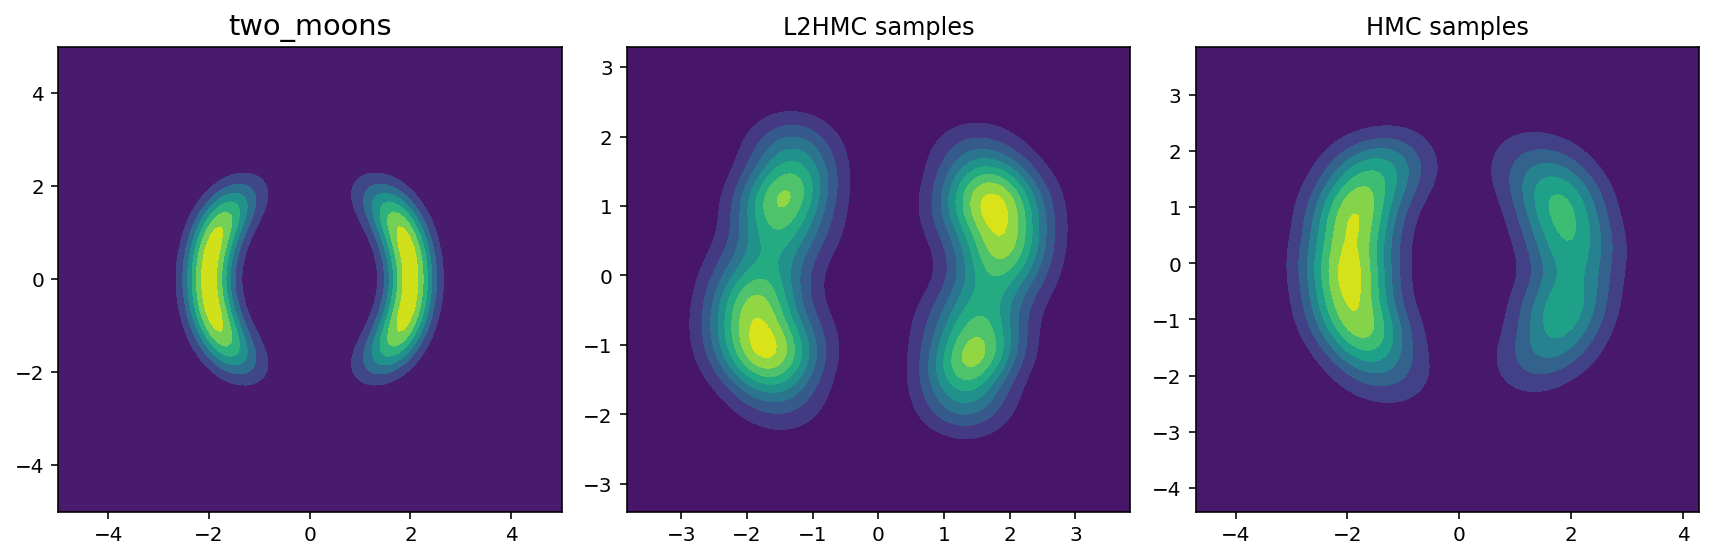

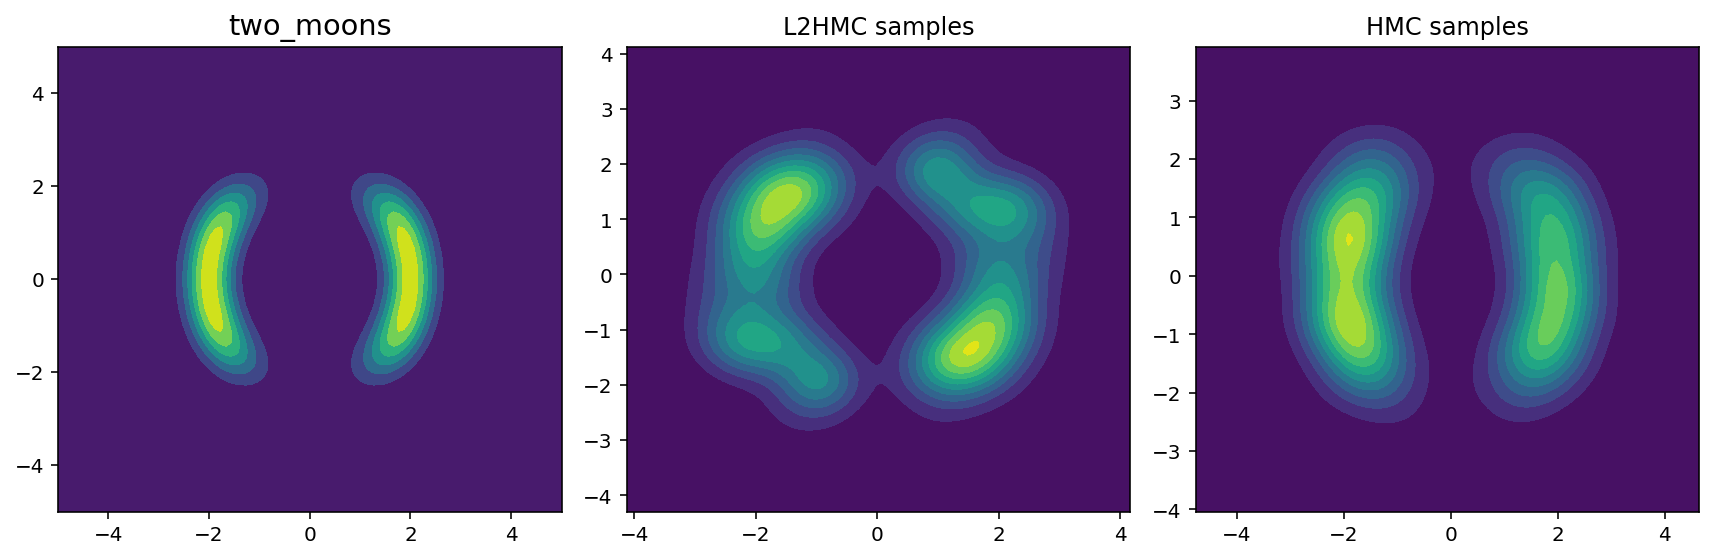

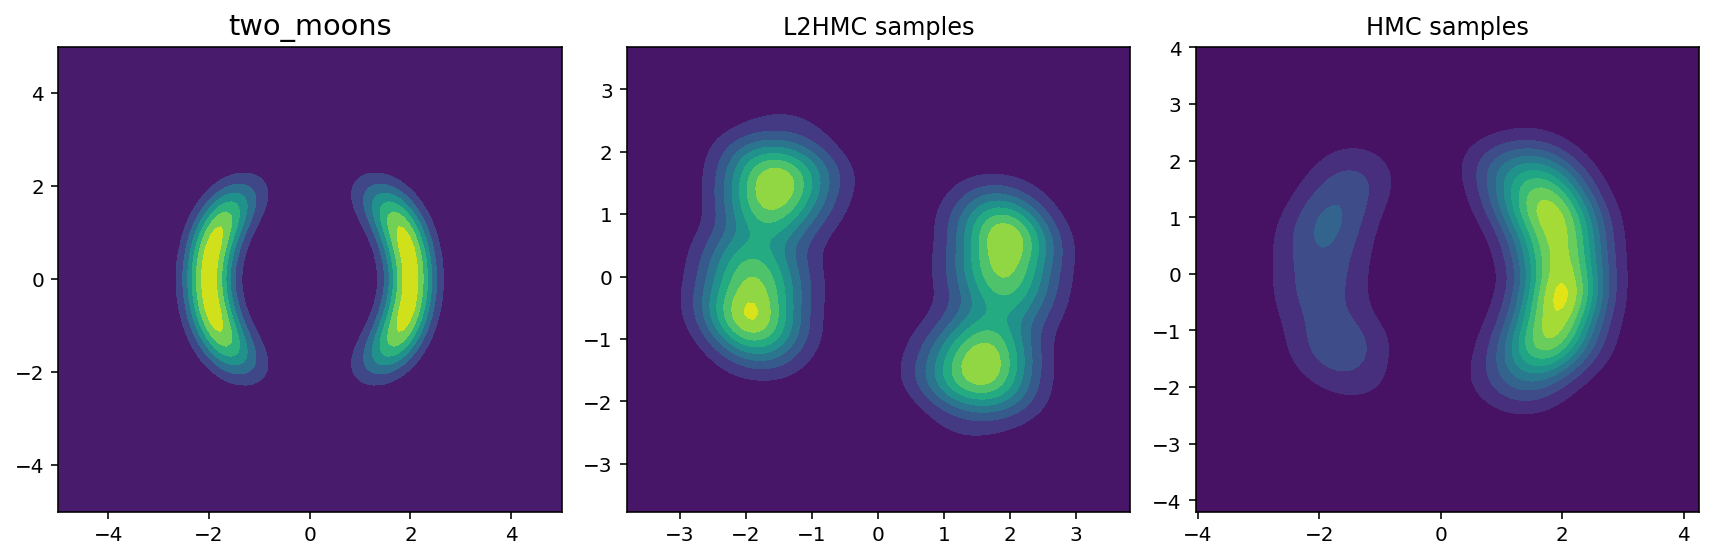

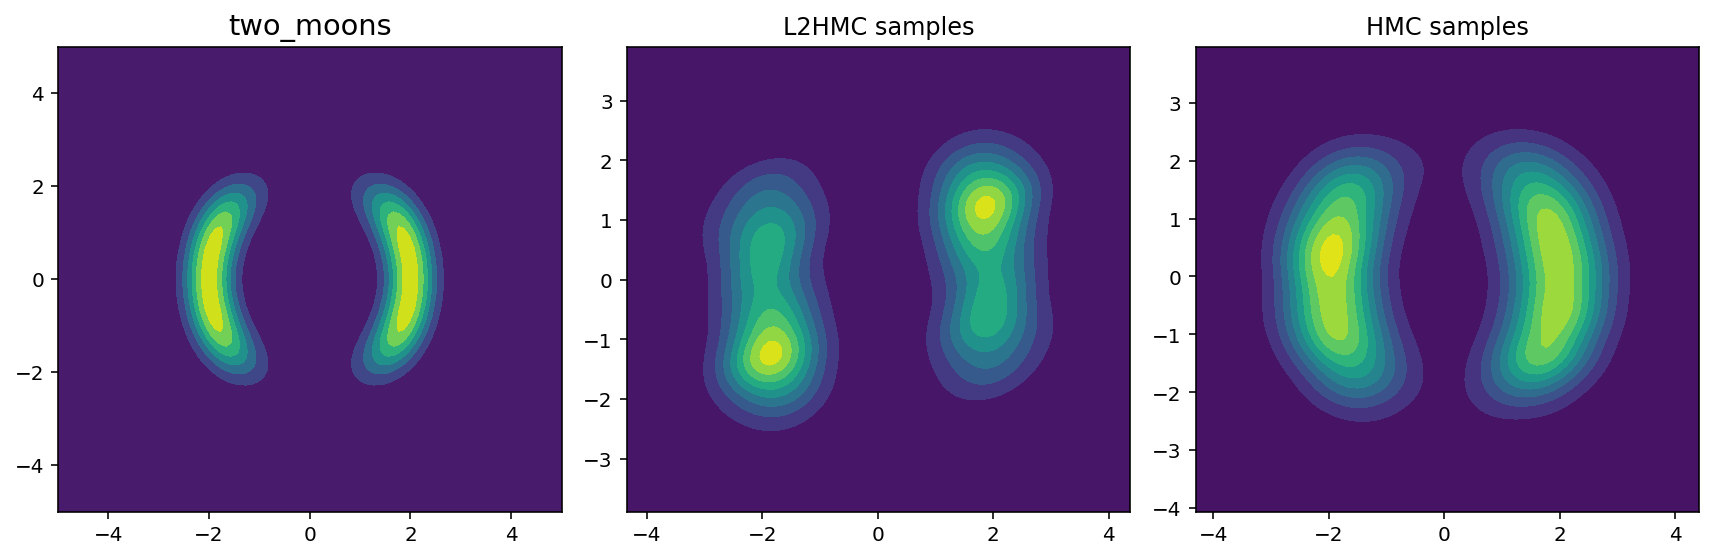

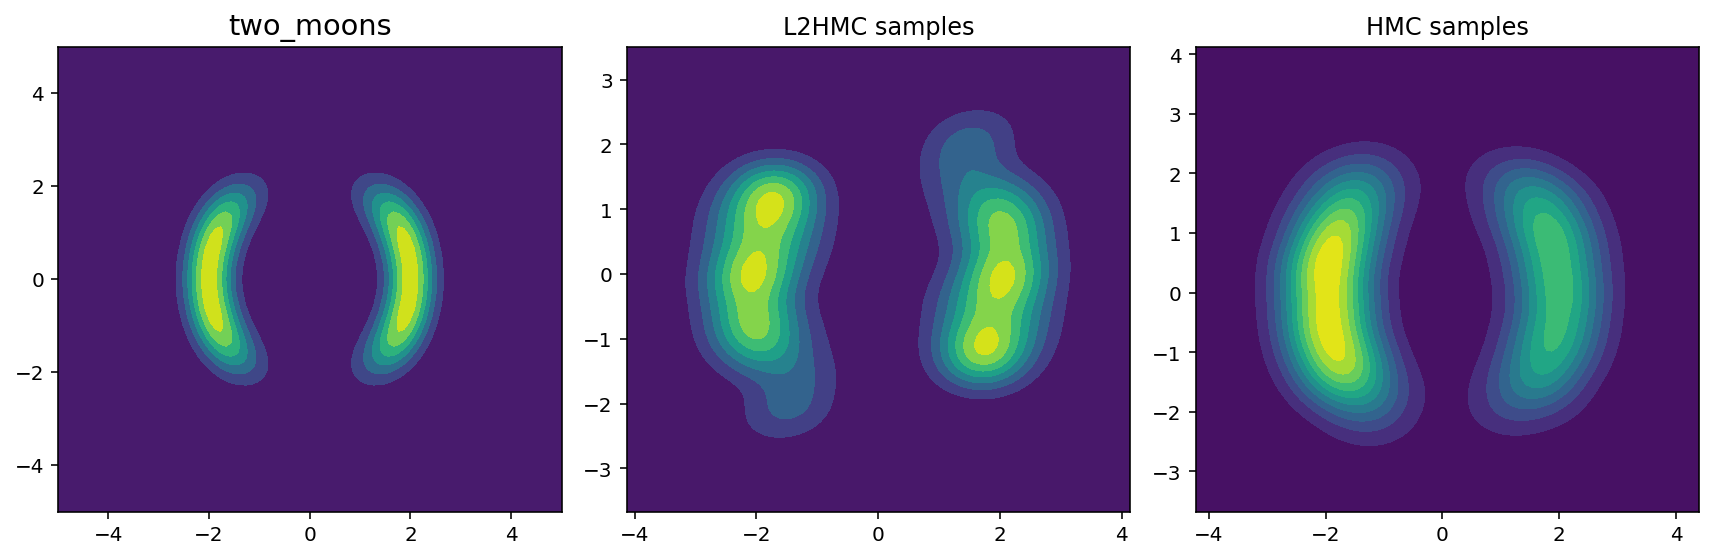

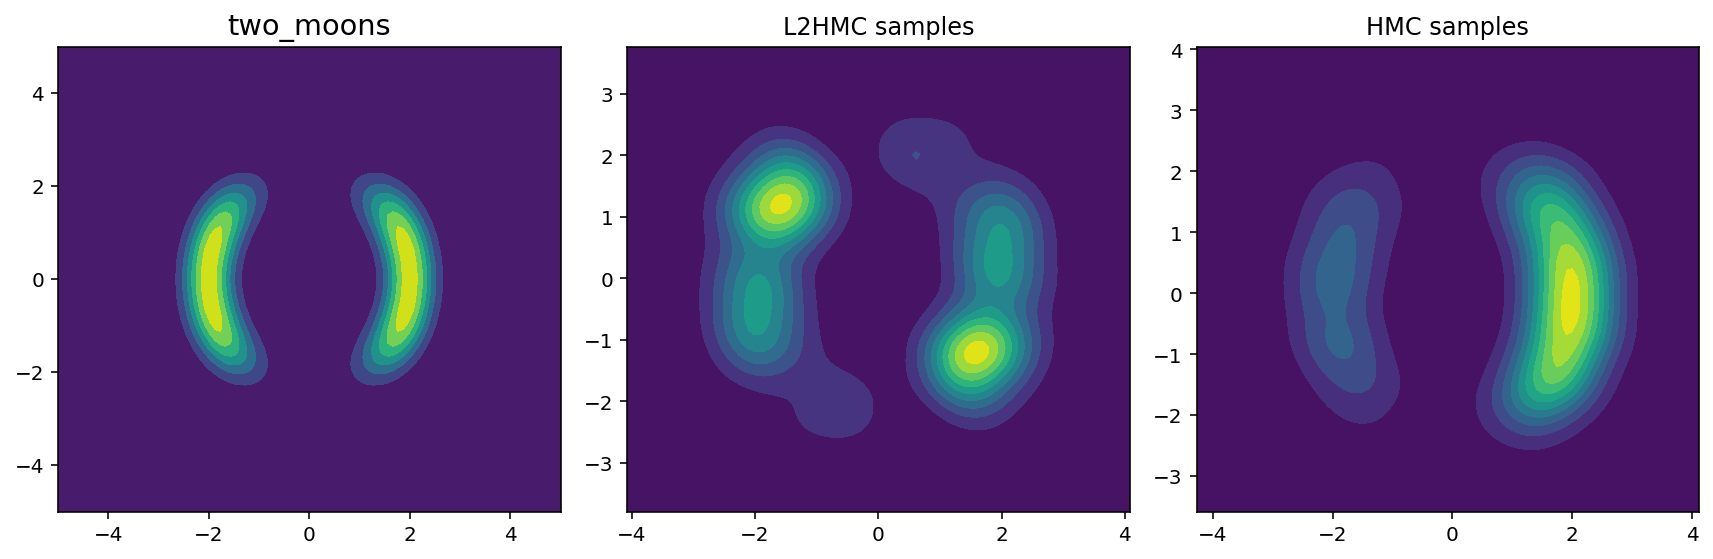

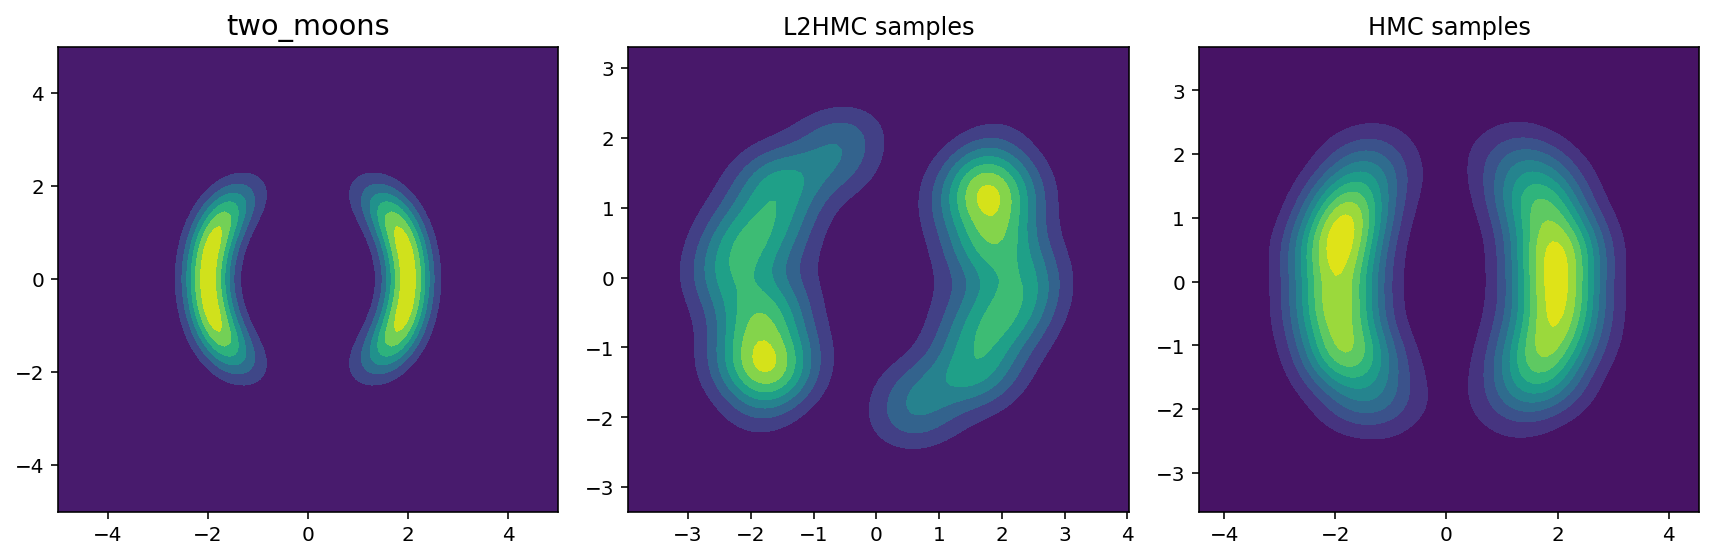

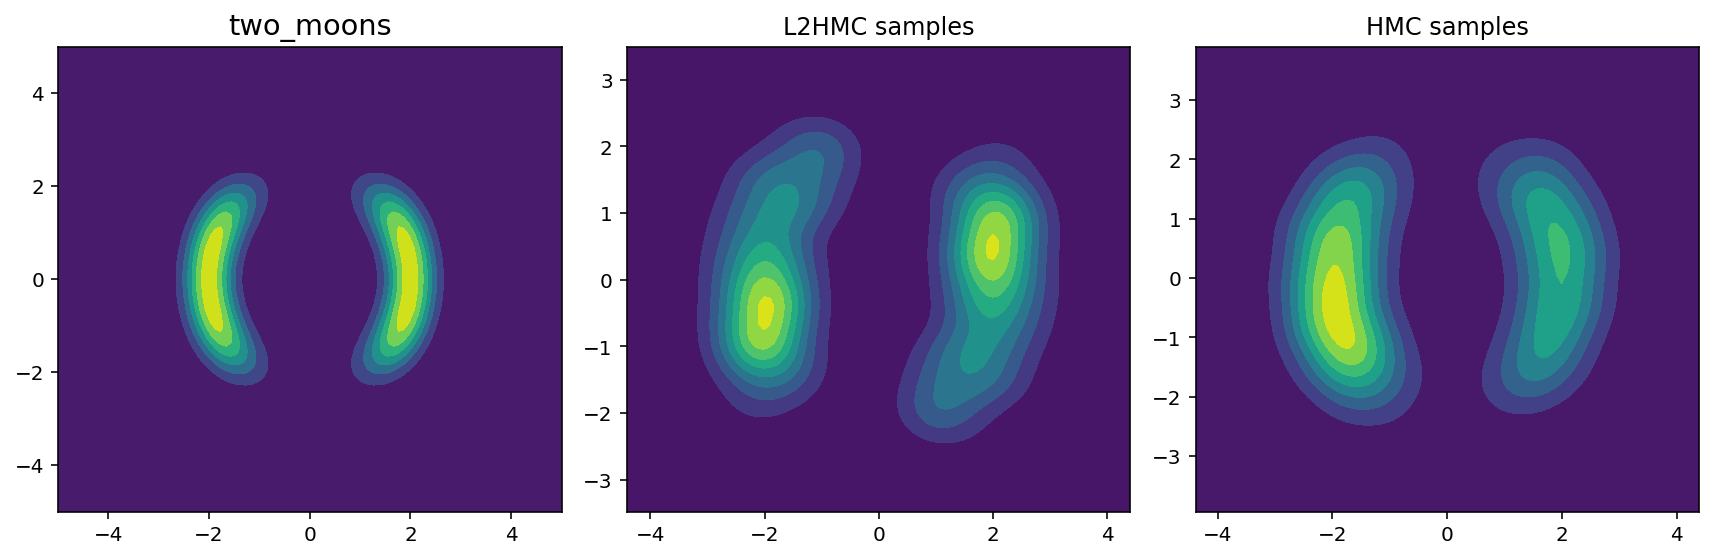

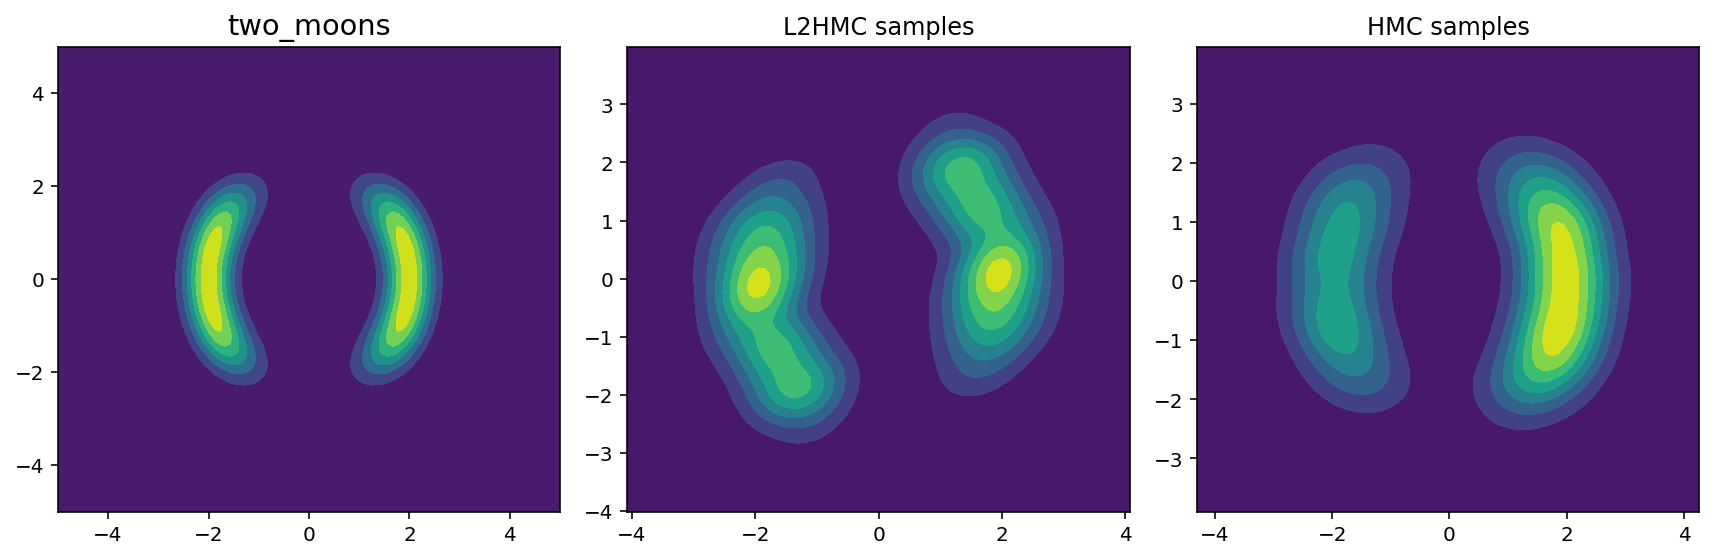

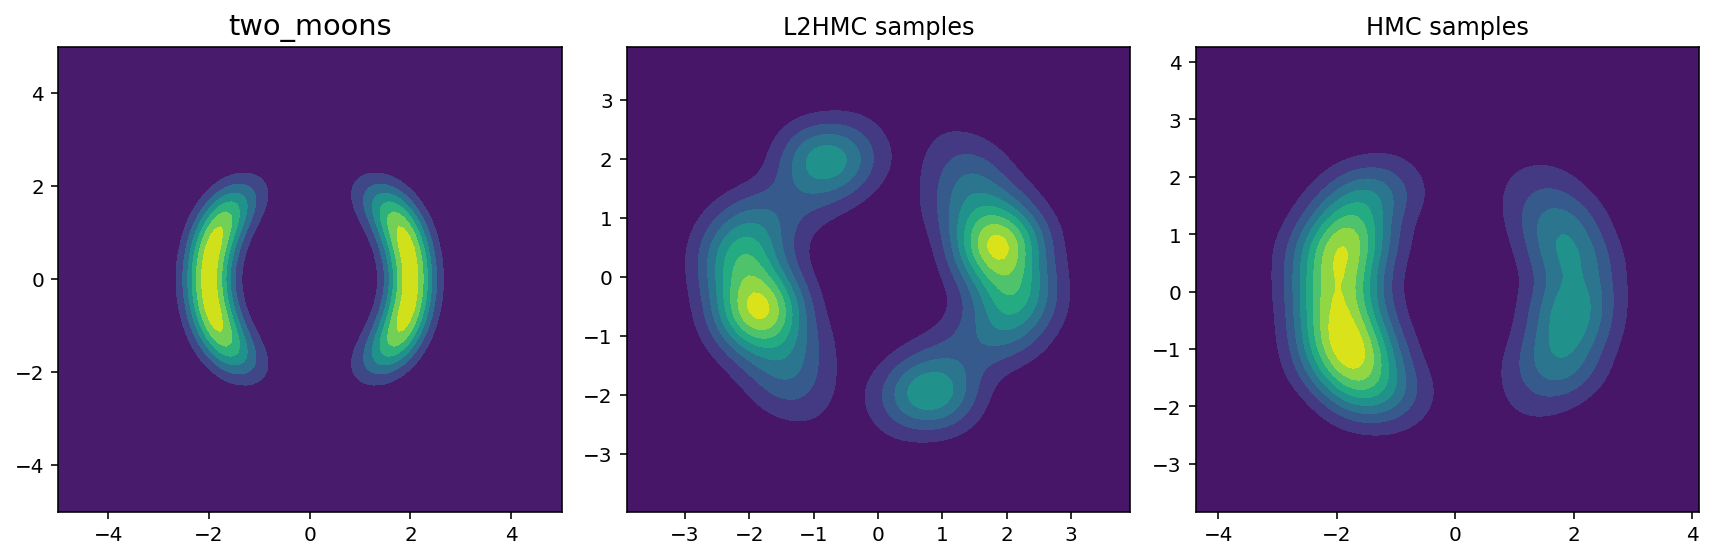

In [24]:
plot_density_estimation(POTENTIAL_FN, x_arr, x_arr_hmc,
                        num_plots=10, title=MODEL_TYPE, cmap='viridis')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

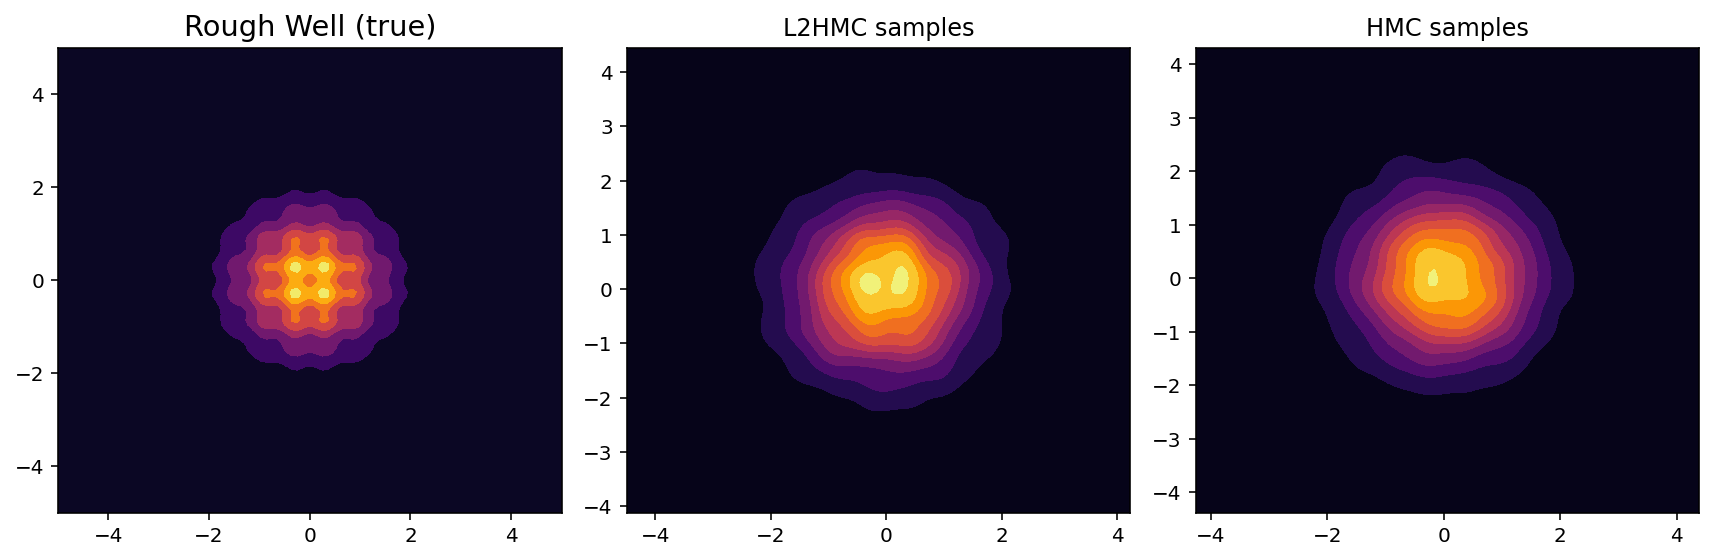

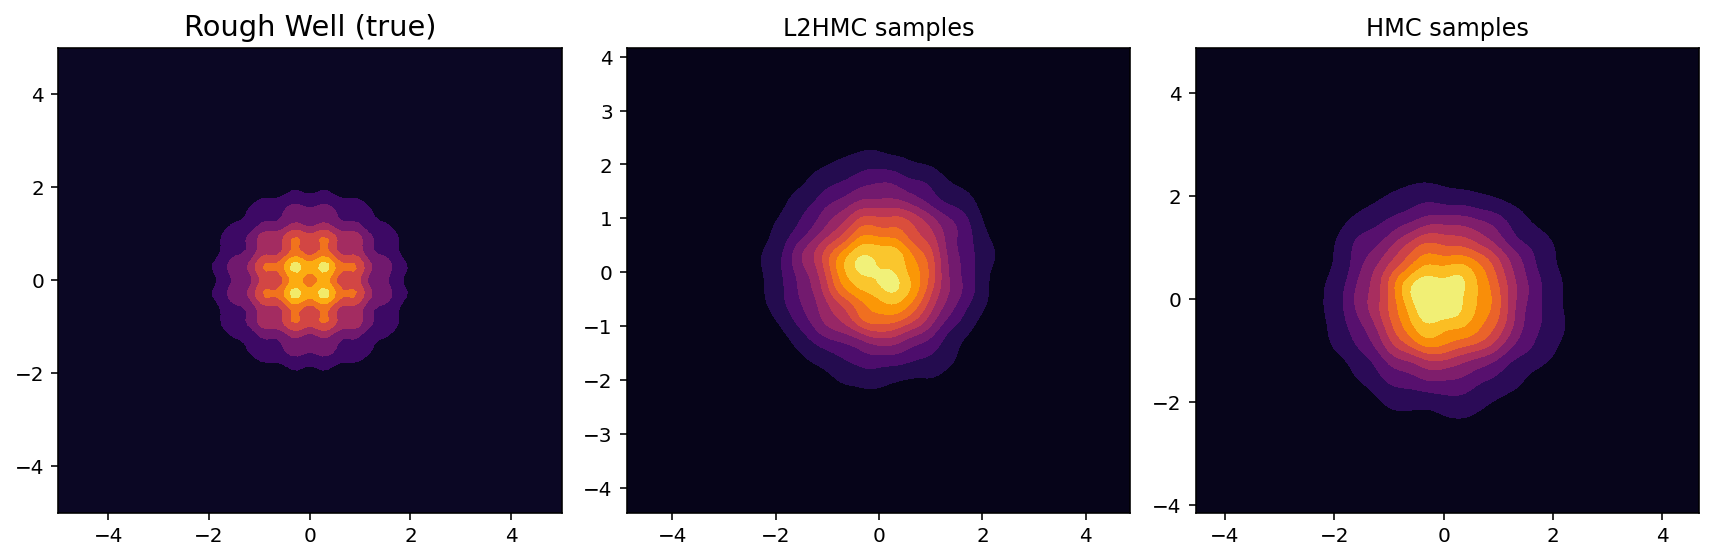

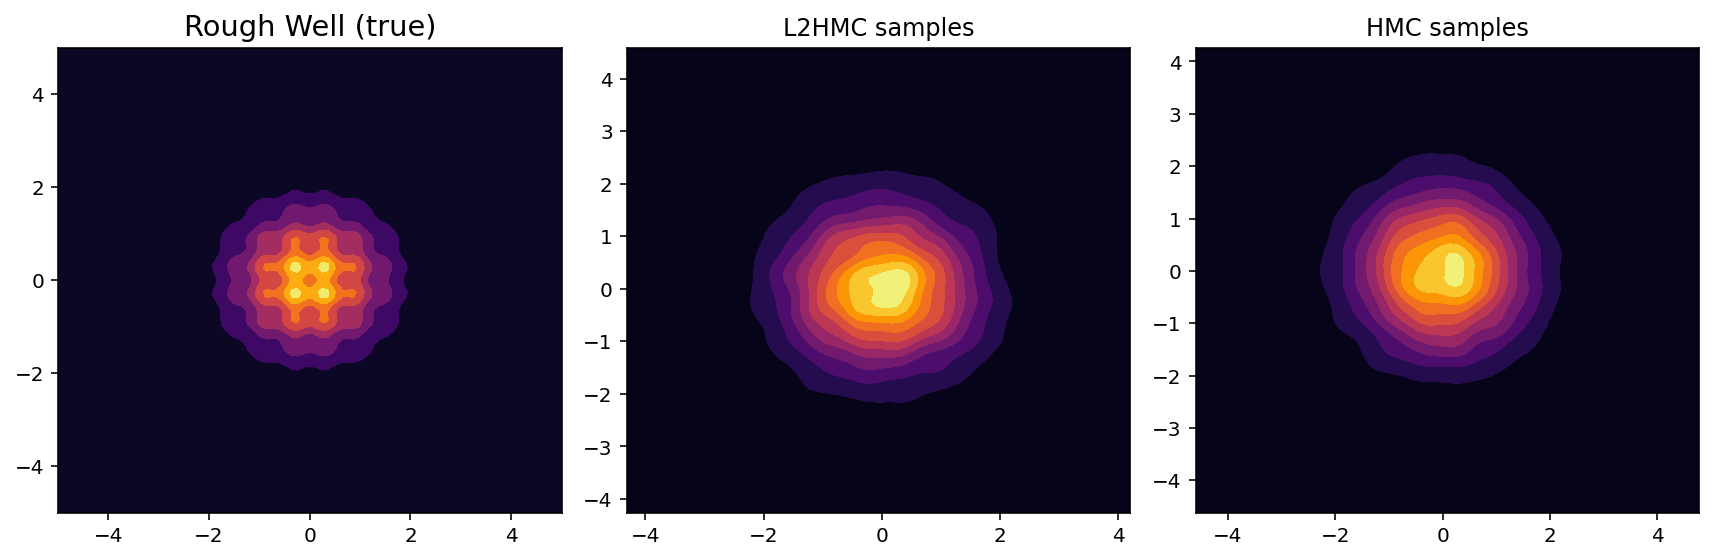

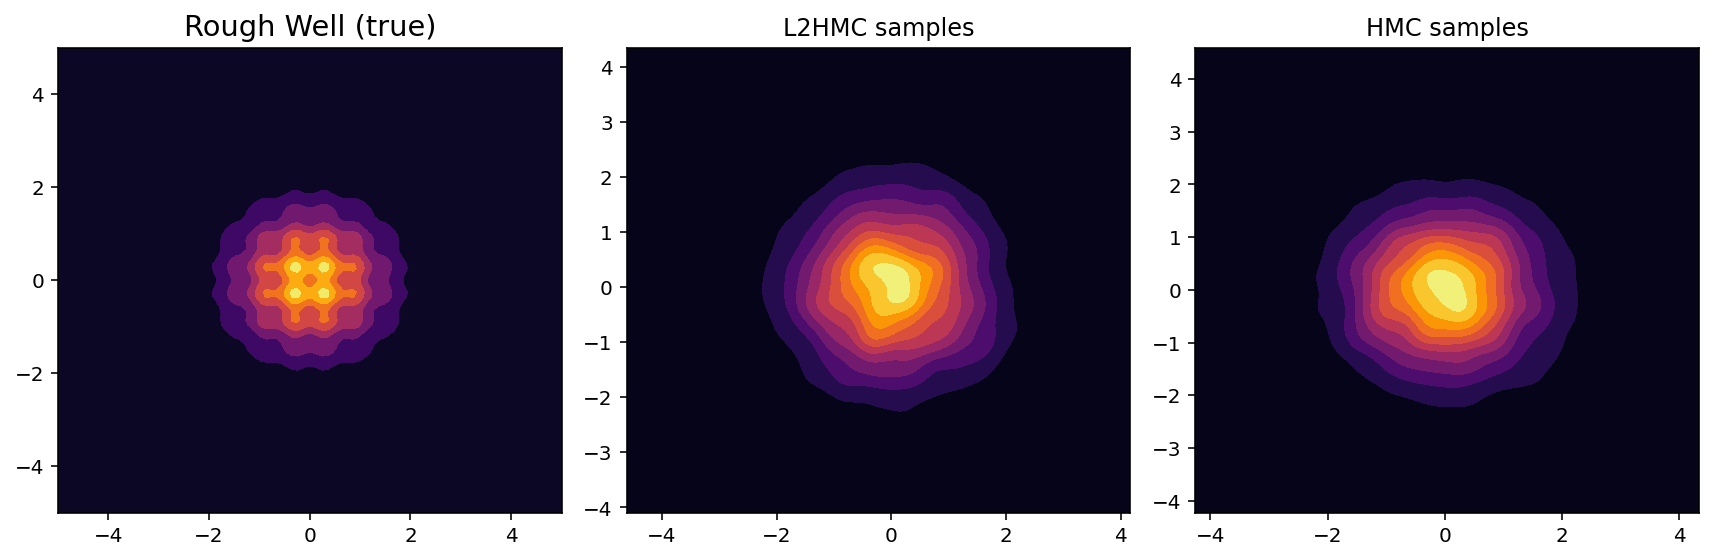

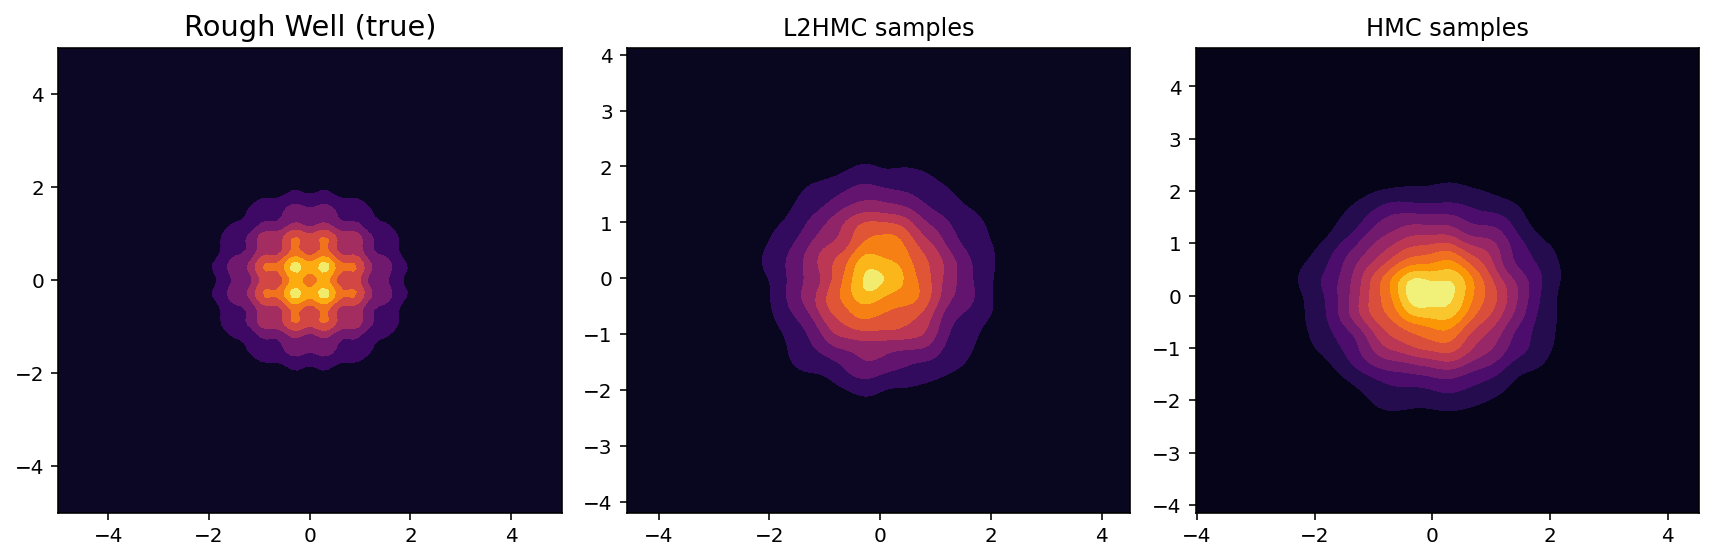

In [77]:
from utils.distributions import contour_potential
xl2hmc = np.array(x_arr)
xhmc = np.array(x_arr_hmc)

for idx in range(5):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    _ = contour_potential(POTENTIAL_FN, title='Rough Well (true)', ax=axes[0])
    _ = sns.kdeplot(xl2hmc[:, idx, 0], xl2hmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[1])
    _ = sns.kdeplot(xhmc[:, idx, 0], xhmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[2])
    _ = axes[1].set_title('L2HMC samples')
    _ = axes[2].set_title('HMC samples')
    plt.tight_layout()

### L2HMC Samples:

2020-08-31 14:43:10,703:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures
Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


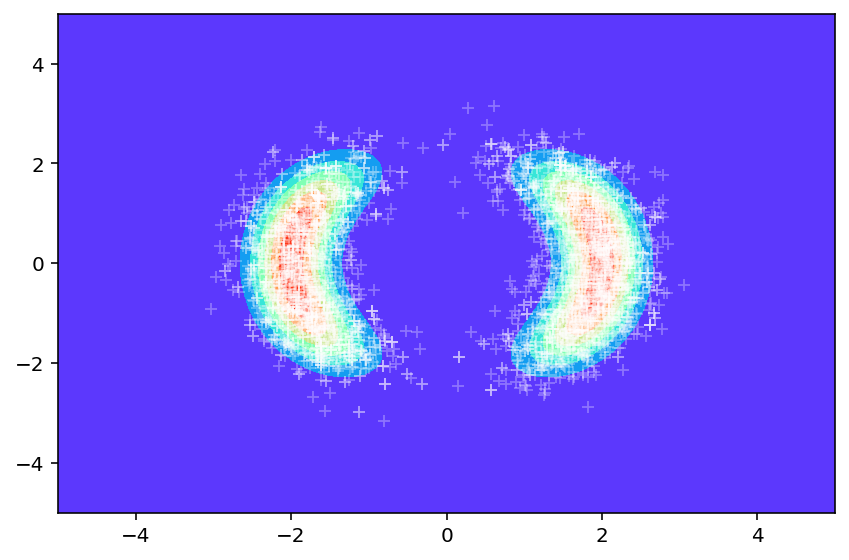

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


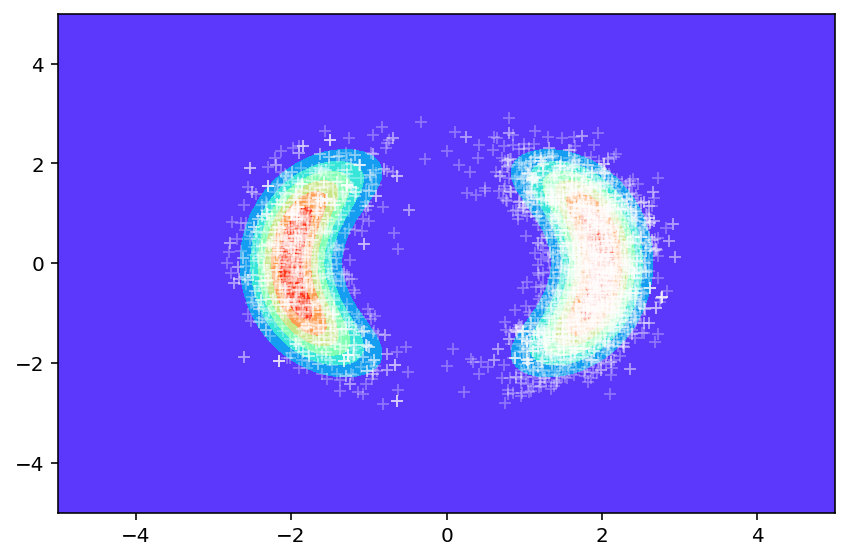

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


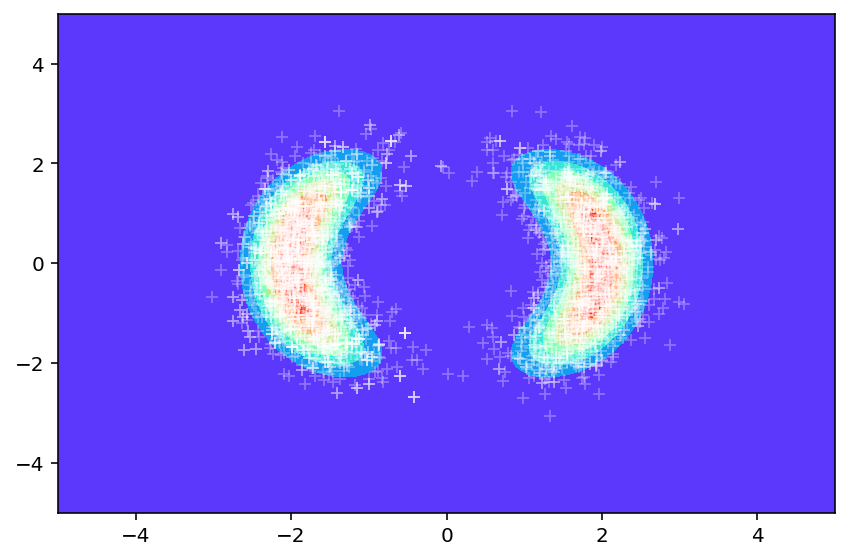

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


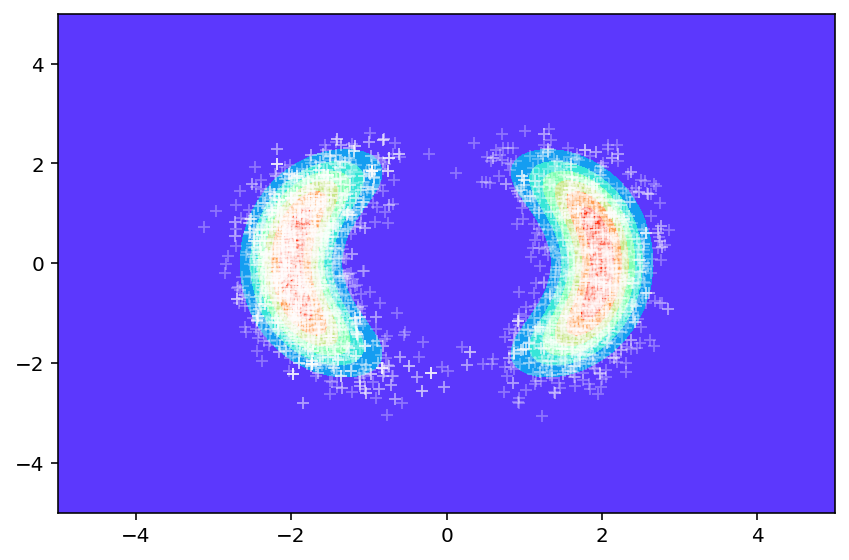

In [19]:
plot_chains(dirs, x_arr, POTENTIAL_FN, label='l2hmc samples', cmap='inferno')

### HMC Samples:

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


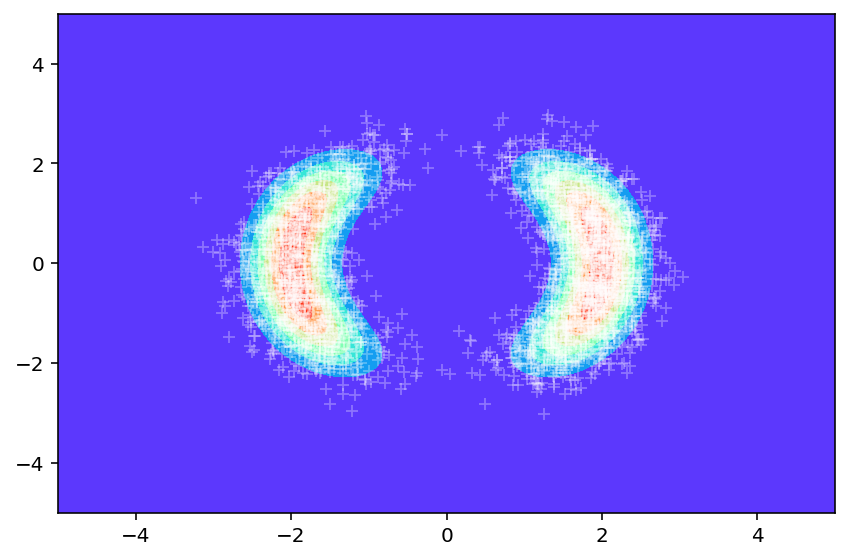

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


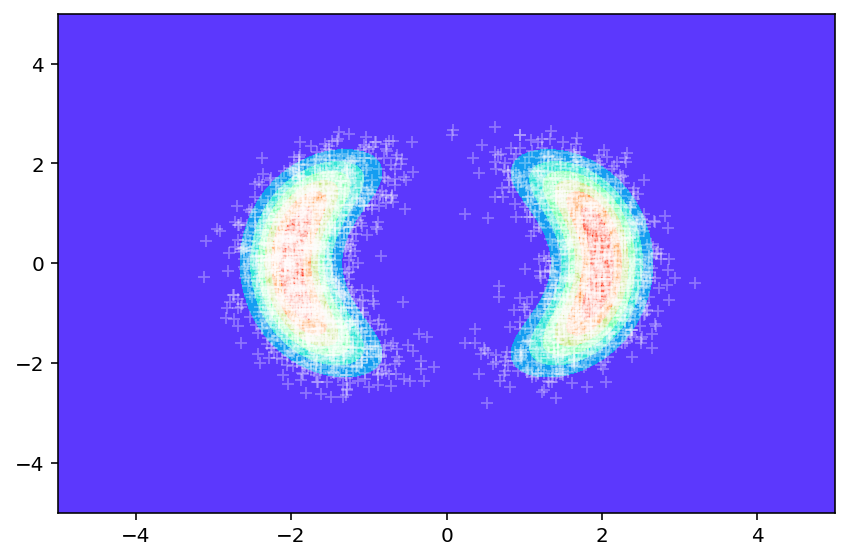

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


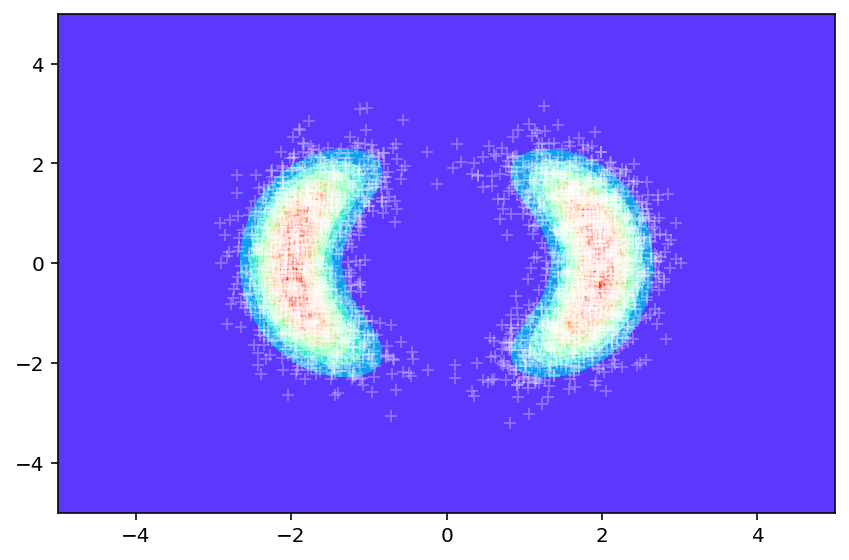

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


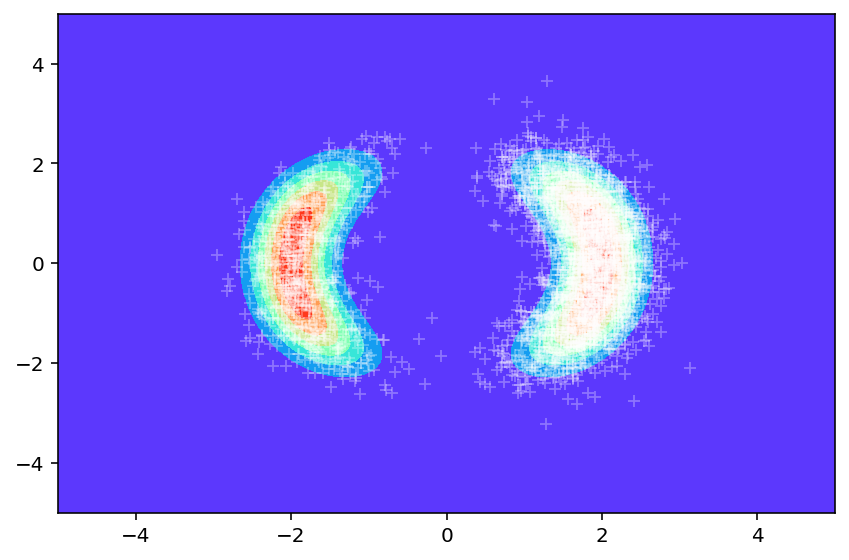

In [20]:
plot_chains(hmc_dirs, x_arr_hmc, POTENTIAL_FN, label='HMC samples', cmap='inferno')